## Introduction

#### Peter Skipper, research and development data scientist

---
This notebook will provide a quick introduction into the mechanics of using CivisML. It's the notebook I wish I had had when I started using CivisML, and it provides a way to start gaining meaning from your data quickly. The use case we'll look at here is a supervised classification problem where we used a publicly available dataset of breast cancer cases available from the UCI Machine Learning Repository[1][2]. Learn more about the [dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/).

CivisML is a machine learning service accessible in Civis Platform. It’s built around scikit-learn, the popular open-source machine learning library for Python. Scikit-learn has a well-defined API, which lets CivisML handle any model that you can define with the library. With CivisML, you can hand a scikit-learn model to Civis Platform and the platform will fit the model, store the results, and plot model diagnostics such as the ROC curve. (You can read how to use it in our [documentation](http://civis-python.readthedocs.io/en/latest/ml.html).)

CivisML uses the Civis Platform to train machine learning models and parallelize their predictions over large datasets. It contains best-practice models for general-purpose classification and regression modeling as well as model quality evaluations and visualizations. All CivisML models use scikit-learn for interoperability with other platforms and to allow you to leverage resources in the open-source software community when creating machine learning models. CivisML automates many of the repetitive tasks a Data Scientist performs in scikit-learn, making it possible to try many more modeling ideas with many fewer lines of code. 

In this notebook, I will explore some of my major use cases (e.g. trying different algorithms, firing off many models in unison with different hyperparameters, and analyzing cross-validated results). 

**CivisML uses the Civis API.  If you'd like to run this code yourself, consider signing up for a [free trial](https://www.civisanalytics.com/civis-platform-signup/).**

---
The Wisconsin Breast Cancer (Diagnostic) Data Set records anonymous data on ~600 patients' cells, along with whether those cells are cancerous or benign. We can create a classifier to predict which cells are dangerous!

---
[1]: O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

[2]: Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

#### TL;DR: Why Would I Use This?
- CivisML easily parallelizes your modeling tasks, making it fast to try lots of ideas
- Diagnostic and other results are accessible in fewer lines of code
- The package works with any scikit-learn estimators, so if you have your own pipeline already you can still get the benefits of CivisML

In [1]:
# packages for downloading the data
import os
import urllib

# packages for munging, plotting, machine learning
import pandas as pd
import numpy as np
import warnings
# xgboost uses the deprecated sklearn.cross_validate module, but we don't depend on it
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import xgboost
import matplotlib.pyplot as plt
%matplotlib inline

# package to help with parallelization
from concurrent import futures

# packages for CivisML
import civis
from civis.ml import ModelPipeline

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print("Pandas version: {}".format(pd.__version__))
print("Civis version: {}".format(civis.__version__))
print("Xgboost version: {}".format(xgboost.__version__))

Pandas version: 0.20.1
Civis version: 1.5.2
Xgboost version: 0.6


## Downloading Data
- First things first, we need to grab the data from UCI ML Repository

In [3]:
%%time
DATA_URL = "http://mlr.cs.umass.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"

if not os.path.isfile('breast_cancer_data.csv'):
    print("Fetching data...")
    opener = urllib.request.URLopener()
    opener.retrieve(DATA_URL, "breast_cancer_data.csv")
    print("File Size: {:.1f} KB".format(os.path.getsize('breast_cancer_data.csv') / (1024*100)))
    print("Finished")
else:
    print("breast_cancer_data.csv already downloaded")

Fetching data...
File Size: 0.2 KB
Finished
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 125 ms


## Munging Data

One of the advantages of Jupyter notebooks is that you can do data formatting and cleaning in one set of cells, use that code to get the data into shape for modeling, and then move on later in the notebook to actually building the models.  Here's an example of the data ETL first, all in pandas.

- We'll add in the column names, and tell pandas that null values are encoded as a '?'.
- We can peek at shape. This is a small table, which I chose to allow for quick training.
- We'll recode the response 4 (cancer) and 2 (benign) as 1 and 0 respectively (keeping care to ensure null values are retained). **I don't have to do this**, but to me it feels more intuitive to deal with ones and zeros

In [4]:
COL_NAMES = ['sample_id', 'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape',
            'marginal_adhesion', 'epithelial_cell_size', 'bare_nuclei', 'bland_chromatin',
            'normal_nucleoli', 'mitoses', 'is_cancer']
df = pd.read_csv("breast_cancer_data.csv", names=COL_NAMES, na_values='?')

print("Shape: ", df.shape)

df['is_cancer'] = [1 if val == 4 else (0 if val == 2 else np.nan) for val in df['is_cancer'] ]
# df.head()

Shape:  (699, 11)


## Training Models

#### Using CivisML built-in algorithms

CivisML was built with two goals in mind: make it really fast and easy to try things, and do not force a user to compromise in terms of model quality and flexibility.  To help make iteration fast and easy, we pre-loaded CivisML with a few of our workhorse algorithms, including a regularized logistic regression, a random forest classifier, and an extra trees classifier. As data scientists, we usually want to quickly try a few different models to get our bearings and gain a sense of if a problem will be easy or hard, so a change to only one line of code can swap these different algorithms in and out for each other.

In the code block below, we start by trying a few different algorithms to fit our classifier. CivisML uses a ModelPipeline object to encapsulate training and predicting. A few important details:

- As mentioned above, CivisML makes a few scikit-learn compatible estimators available. You can see a list of them [here](https://civis-python.readthedocs.io/en/v1.5.2/ml.html#custom-models). 
- sparse_logistic will create an L1 penalized logistic regression for variable selection, then build an unpenalized logistic regression from the selected variables
- I need to explicitly pass which column is the dependent variable

I'll initialize the pipelines below

In [5]:
workflows = ['sparse_logistic',
             'random_forest_classifier',
             'extra_trees_classifier']

models = []
for wf in workflows:
    model = ModelPipeline(model=wf,
                          dependent_variable="is_cancer",
                          model_name=wf)
    models.append(model)

#### Trying different hyperparameters

Another thing I'm often doing is building lots of models with tweaked hyperparameters, to see what fits best. Often the choice of hyperparameter has a bigger impact on the outcome than the model itself, so it was important to use to make hyperparameter searches as easy as possible.  

Let's add a bunch of gradient_boosted_classifiers with different parameters from the defaults.

The code below passes a dict of hyperparameter choices to the ModelPipeline. **CivisML will automatically try all combinations of hyperparameter choices, and report back results from the best one** on the cross-validated data set.  We're building eight models here and comparing them all, and the only price we pay is four extra lines of code.

In [6]:
cv_params = {'learning_rate': [0.01, 0.2],
             'n_estimators': [50, 200],
             'max_depth': [1, 2]}
model = ModelPipeline(model='gradient_boosting_classifier',
                      dependent_variable="is_cancer",
                      cross_validation_parameters=cv_params,
                      model_name='best_gbc_from_hyperparam_search')
models.append(model)

#### Creating your own estimator

Last but not least, I might want to roll my own classifier, apart from CivisML builtins. We think this bring-your-own-model capability is one of the most important and powerful features of CivisML, because it allows a technical user to maintain a high degree of flexibility regarding what model they want to fit. It's easy to take your existing code and still get the benefits of CivisML parallelizability and metrics reporting.

I've been playing around a lot recently with xgboost, let's create and parameterize our own XGBClassifier.

In [7]:
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.01)
model = ModelPipeline(model=xgb,
                      dependent_variable='is_cancer',
                      model_name='xgb_classifier')
models.append(model)

---
Great! In about fifteen lines of code I've queued up about a dozen models, and can train them all in a loop. On the backend, CivisML will make it really simple to kick off parallel jobs for each of these models. Creating a ModelPipeline is much like creating a scikit-learn model, in that it doesn't cause anything to happen computationally until the user calls "train" or "predict."

I want to call your attention to something important here that I'm not doing.  I'm not writing any code to cross-validate my models.  If this were raw scikit-learn code, there would need to be a bunch of extra boilerplate code to make sure my data is properly shuffled, split it into cross-validation splits, train and test for each fold, and then aggregate all the folds back into a single set of metrics and a single model.  **CivisML takes care of the cross-validation automatically. I never have to write boilerplate cross-validation code, or worry about cross-valication mistakes invalidating my conclusions.  It just works.**

The futures.wait function will block until all models finish training. Again, though, they're training *in parallel* so this might take a few minutes, instead of ten or twenty. Time for a coffee, maybe?

In [8]:
%%time 
future_jobs = [model.train(df=df) for model in models]
futures.wait(future_jobs)

CPU times: user 1.48 s, sys: 116 ms, total: 1.59 s
Wall time: 2min 46s


The output of model.train() is a futures object. Calling .succeeded() on it will allow me to check the status of my job.

Let's make sure that the state of each training job is "succeeded." Jobs might fail, for example, if we drop a connection with the server. If this is the case, we can simply rerun the pipeline.

In [9]:
all_success = all([model_fut.succeeded() for model_fut in future_jobs])
print("All successful: {}".format(all_success))

All successful: True


## Visualizing Results

Another piece of boilerplate code (besides cross-validation) that I don't want to rewrite over and over is the code for calculating model performance metrics. I want to automatically get a set of standard metrics for every model I train, and CivisML has baked-in functionality to return metrics like accuracy, true positive rate, false positive rate, and area under the ROC curve for every model.  This makes comparing my models, and picking the best one, very easy.

Let's create ROC curves for our cross-validated training results so that we can get a visual idea of how well our models are performing. CivisML provides validation data in the **metrics** dict of each futures object. Pulling this out and graphing it makes it easy to evaluate our models. These models appear to be doing fantastic!

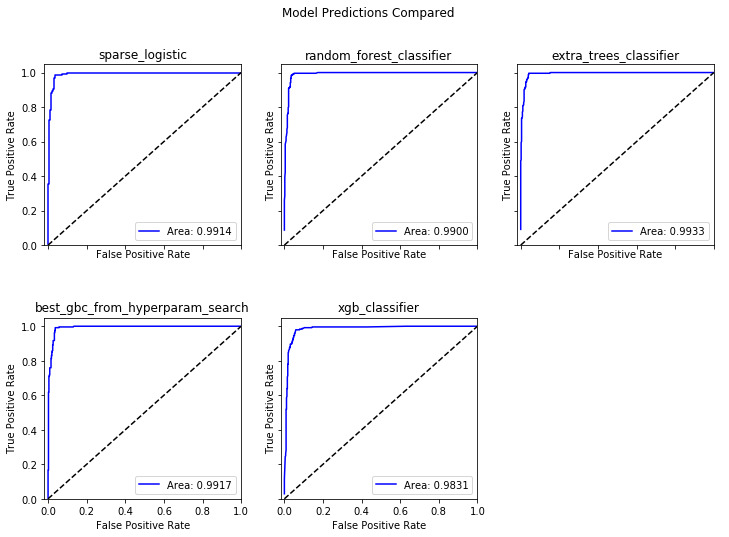

In [10]:
def extract_roc(fut_job):
    metrics = fut_job.metrics
    return metrics['roc_curve']['fpr'], metrics['roc_curve']['tpr'], metrics['roc_auc']


def plot_one_roc_curve(ax, model_name, fpr, tpr, roc_auc):
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.set_xlim([-0.02, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title(model_name)
    ax.plot(fpr, tpr, color='blue', label="Area: {:.4f}".format(roc_auc))
    ax.plot([0,1], [0,1], 'k--')
    ax.legend(loc="lower right")
    
    
rocs = [extract_roc(fut_job) for fut_job in future_jobs]
model_names = [model.model_name for model in models]
fig, axes = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(12,8))
fig.suptitle("Model Predictions Compared")
fig.subplots_adjust(hspace=0.4)

# Last axis object has no data, hide it
axes[-1, -1].axis('off')

axes = axes.ravel()[:5]
assert len(rocs) == len(model_names)
assert len(axes) == len(model_names)
for ax, model_name, roc in zip(axes, model_names, rocs):
    fpr, tpr, roc_auc = roc
    plot_one_roc_curve(ax, model_name, fpr, tpr, roc_auc);
    

## Scoring New, Unlabeled Data
In our opinion, scoring is where CivisML really shines.  For many (most?) models, we have a modest-sized training set but a very large dataset on which we want to score the model. For most of our work at Civis, the training set size might be a few thousand cases, while the scoring set is 250 million (or roughly the entire adult population of the United States). **On my laptop, it would take several days to score a dataset this large. CivisML has built-in parallelization of scoring jobs, so that work gets spread across dozens of computers and it takes the scoring time from days to under an hour.**

In this case, I won't score a dataset that big because I don't really need to in order to demonstrate the scoring interface. However, just to take this all to its conclusion, because all this work is happening in a notebook on platform, I could imagine launching a huge scoring job, then closing the laptop and hopping on the bus home. Because everything is running in the cloud, the model keeps scoring during the bus ride home, while I'm walking the dog, as I eat dinner, and when I check in after washing the dishes, the model is all scored and ready for use.  If I needed to do this on my laptop, not only would it take forever, but I wouldn't be able to close my laptop during that time, because doing so would kill the scoring job.

I had a complete data set to start, but I'll simulate a test data set here by sampling my original df.

In [11]:
test_set = df.sample(frac=0.2, random_state=47)

Like training jobs, scoring jobs can also be fired off in parallel for some sweet speedy scoring goodness

In [12]:
%%time
future_scores = [model.predict(df=test_set) for model in models]
futures.wait(future_scores)

CPU times: user 936 ms, sys: 84 ms, total: 1.02 s
Wall time: 31.4 s


Again, let's make sure that all our scoring jobs completed successfully, and re-run if necessary!

In [13]:
all_success_scoring = all([score_fut.succeeded() for score_fut in future_scores])
print("All successful scoring: {}".format(all_success_scoring))

All successful scoring: True


And now the most important part--getting predictions from my model!

Pulling out tables of results is as simple as accessing the 'table' attribute of my scoring job. We can check what the probability of cancer is according to our first model and the first 5 rows of the test set below.

In [14]:
score_tables = [score_job.table for score_job in future_scores]
score_tables[0].head()

,is_cancer_1
0,0.074928
1,0.003622
2,0.990506
3,0.999862
4,0.800179


## Model Persistence

CivisML automatically stores your training jobs, which is convenient when you're dealing with larger datasets and training is slower. To grab a previously trained model, **simply find your model's job_id and run_id.** My 3rd job (the extra trees classifier) slightly outperformed the rest, so I'll look at it specifically.

In [15]:
extra_trees_job_id = future_jobs[2].job_id
extra_trees_run_id = future_jobs[2].run_id
print("Job Id: {}".format(extra_trees_job_id))
print("Run Id: {}".format(extra_trees_run_id))

Job Id: 6959620
Run Id: 57698098


- from_existing takes job_id and run_id, and reloads the trained model
- I'll call .result() on my predict job to get it to block until finished

In [16]:
loaded_model = ModelPipeline.from_existing(extra_trees_job_id, extra_trees_run_id)

loaded_fut = loaded_model.predict(df=test_set)
print(loaded_fut.result()['state'])
loaded_fut.table.head()

succeeded


,is_cancer_1
0,0.0
1,0.0
2,1.0
3,1.0
4,1.0
